## RBD data processing

From our paper, this is how this data was collected: 
> All the SARS-CoV-2 spike protein sequences were downloaded from GISAID (Elbe and Buckland‐Merrett, 2017) as of version 20230203 followed by MD5-based search for deduplication and removal of sequences with a length shorter than 600aa or containing any unknown residues (X), we obtained a dataset of 312,888 unique sequences. Using the reference sequence of RDB region (YP_009724390:319..541), we performed similarity search against the dataset using DIAMOND blastp algorithm (Buchfink et al., 2021) and extracted 312,783 RBD regions that align with the complete 223aa RBD region. All the four data sets are available for download. Sequences and metadata from GISAID can be accessed using the EPI_SET ID: EPI_SET_231127oe.

More recent data collection in May saw an increase in sequences to 347,624. There are 200 sequences that are present in the noX.RBD fasta file, but not in the GISAID metadata file. Metadata was also retrieved by parsing protein fasta header.

We applied this bash command to isolate the variant labels from the metadata file to match with the sequence IDs in the fasta file:```cat spikeprot0528.clean.uniq.noX.RBD.metadata.tsv | cut -f 5,16 | awk '{print $1, $3}' > spikeprot0528.clean.uniq.noX.RBD.metadata_variants.txt```. Let's take a closer look at the metadata and fasta file to confirm the numbers from before... We have 347432 total rows of data in the metadata.

---
Load in the fasta data and meta data. We'll right merge these on "Accession" to the metadata_df, since it was missing ~200 sequences. For any variant with NaN, I'll just specify it as "UNSPECIFIED". 

In [1]:
import os
import pandas as pd
from Bio import SeqIO

# Define paths
data_dir = "../../data/rbd/original"
fasta_file = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD.fasta')
save_as = os.path.join(data_dir, '../spikeprot0528.clean.uniq.noX.RBD.metadata.variants.csv')

# Load fasta
fasta_data = []
for record in SeqIO.parse(fasta_file, "fasta"):
    fasta_data.append([record.id, str(record.seq)])
fasta_df = pd.DataFrame(fasta_data, columns=['Accession', 'Sequence'])

# Load variant metadata
metadata_file = os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD.metadata.variants.txt')
metadata_df = pd.read_csv(metadata_file, sep=" ", header=0)

# Merge with metadata
merged_df = pd.merge(fasta_df, metadata_df, on='Accession', how='right')

# Rename columns for consistency
merged_df = merged_df.rename(columns={'Accession': 'seq_id', 'Sequence': 'sequence', 'Variant': 'variant'})

# Replace NaN values in 'variant' column with 'UNKNOWN'
merged_df['variant'] = merged_df['variant'].fillna('UNKNOWN')

# Save to CSV
merged_df.to_csv(save_as, index=False)

# Display the merged dataframe
merged_df

,seq_id,sequence,variant
0,EPI_ISL_5120698,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
1,EPI_ISL_5123727,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
2,EPI_ISL_14904955,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
3,EPI_ISL_5119677,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
4,EPI_ISL_14904971,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
...,...,...,...
347427,EPI_ISL_14903692,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
347428,EPI_ISL_14902388,RVQPTESIVRFPNITNLCPFDEVFNATTFASVYAWNRKRISNCVAD...,Omicron
347429,EPI_ISL_14905423,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
347430,EPI_ISL_5123715,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta


Split the data.

In [2]:
import pandas as pd
import random

def split_csv(rnd_seed: int, input_csv: str):
    """
    Split csv file into train and test datasets.
    """
    # Output file names
    train_csv = input_csv.replace('.csv', '_train.csv')
    test_csv  = input_csv.replace('.csv', '_test.csv')

    # Load the CSV file into a DataFrame
    df = pd.read_csv(input_csv)

    # Shuffle the data using the random seed
    df = df.sample(frac=1, random_state=rnd_seed).reset_index(drop=True)

    # Calculate the split index
    split_idx = int(0.8 * len(df))

    # Split the data
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    # Save the splits
    train_df.to_csv(train_csv, index=False)
    test_df.to_csv(test_csv, index=False)

    print(f'Total: {len(df)}, Train: {len(train_df)}, Test: {len(test_df)}')

split_csv(rnd_seed=0, input_csv=save_as)

Total: 347432, Train: 277945, Test: 69487


Take a look at the distributions in the data. First is the variant distribution, which is also **INSERT** in our paper. We can see that 3 variants stand out the most: Alpha, Delta, and Omicron. We utilize these three in the clustering notebooks, where we plot UMAP, t-SNE, or HDBSCAN plots.

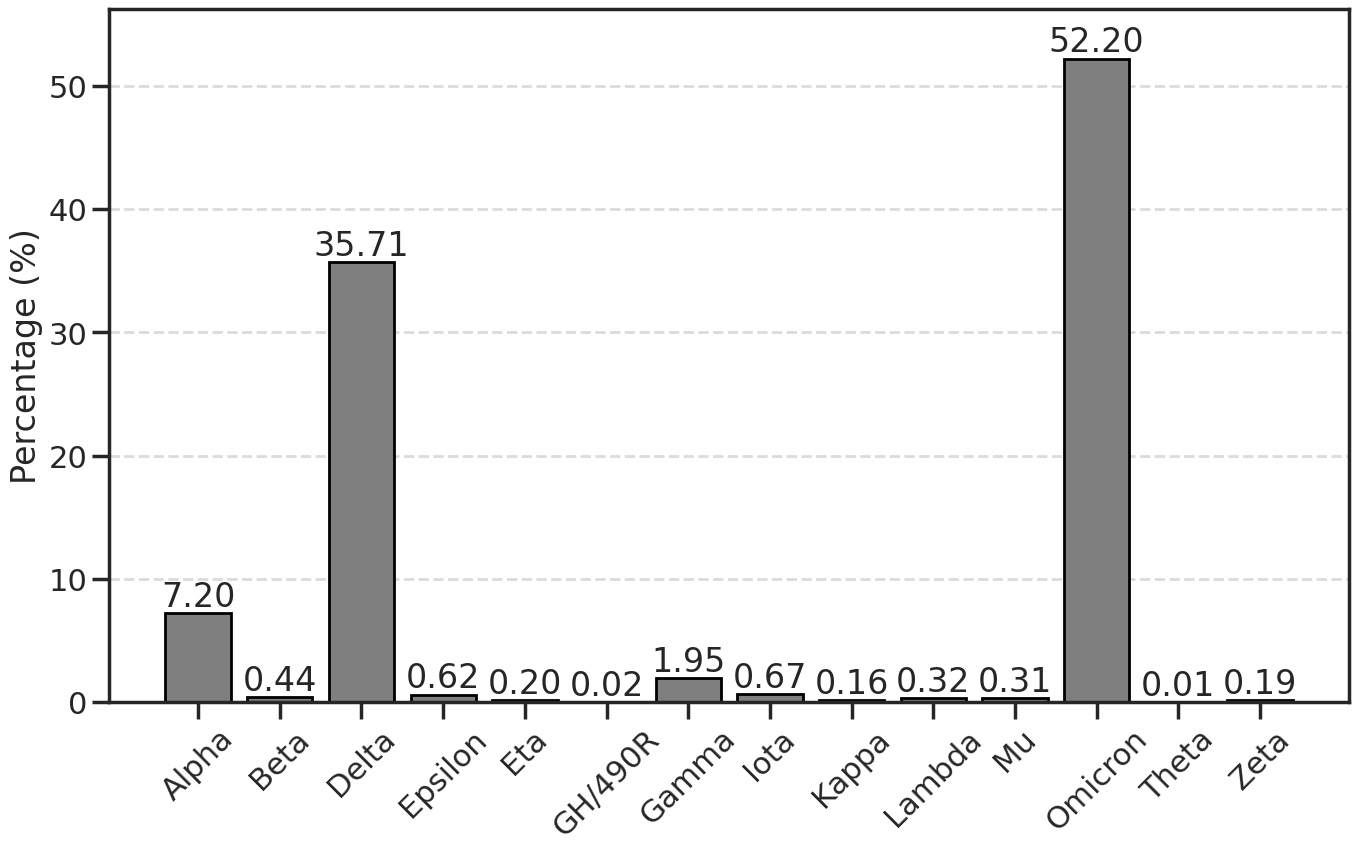

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_variant_distribution(csv_file:str):
    df = pd.read_csv(csv_file, sep=',', header=0)
    df = df[df['variant'] != "UNKNOWN"]

    all_variants = sorted(np.unique(df['variant']))
    variant_percentages = [(df['variant'] == variant).mean() * 100 for variant in all_variants]

    # Create a bar plot to visualize the distribution
    sns.set_style("ticks")
    sns.set_context("poster")
    fig, ax = plt.subplots(figsize=(16, 9))

    x = np.arange(len(all_variants))
    bars = plt.bar(x, variant_percentages, color="tab:grey", edgecolor='black')

    # Add bar labels
    for i, percentage in enumerate(variant_percentages):
        plt.text(x[i], percentage, f'{percentage:.2f}', ha='center', va='bottom')
    
    plt.xticks(x, all_variants, rotation=45)
    plt.ylim(0, max(variant_percentages)+4)
    plt.ylabel('Percentage (%)')
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    save_path = "bar/rbd_variant_distribution"
    plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')

data_file = "../../data/rbd/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.csv"
plot_variant_distribution(data_file)

Next, we take a look at the distribution of amino acids across all sequences. This is useful for comparing against our original BERT model runner's heatmap in our paper. We notice that the amino acid Methionine, "M", is our lowest performing amino acid, but also the amino acid we have least of. 

M count: 3277 AAs, n seqs with M: 3262 (out of 347432), % seqs with M: 0.94%
defaultdict(<class 'list'>, {'Omicron': [2928, 13], 'Delta': [86, 0], 'Alpha': [55, 0], 'UNKNOWN': [167, 2], 'Gamma': [6, 0], 'Zeta': [2, 0], 'Iota': [1, 0], 'Eta': [1, 0], 'Mu': [1, 0]})


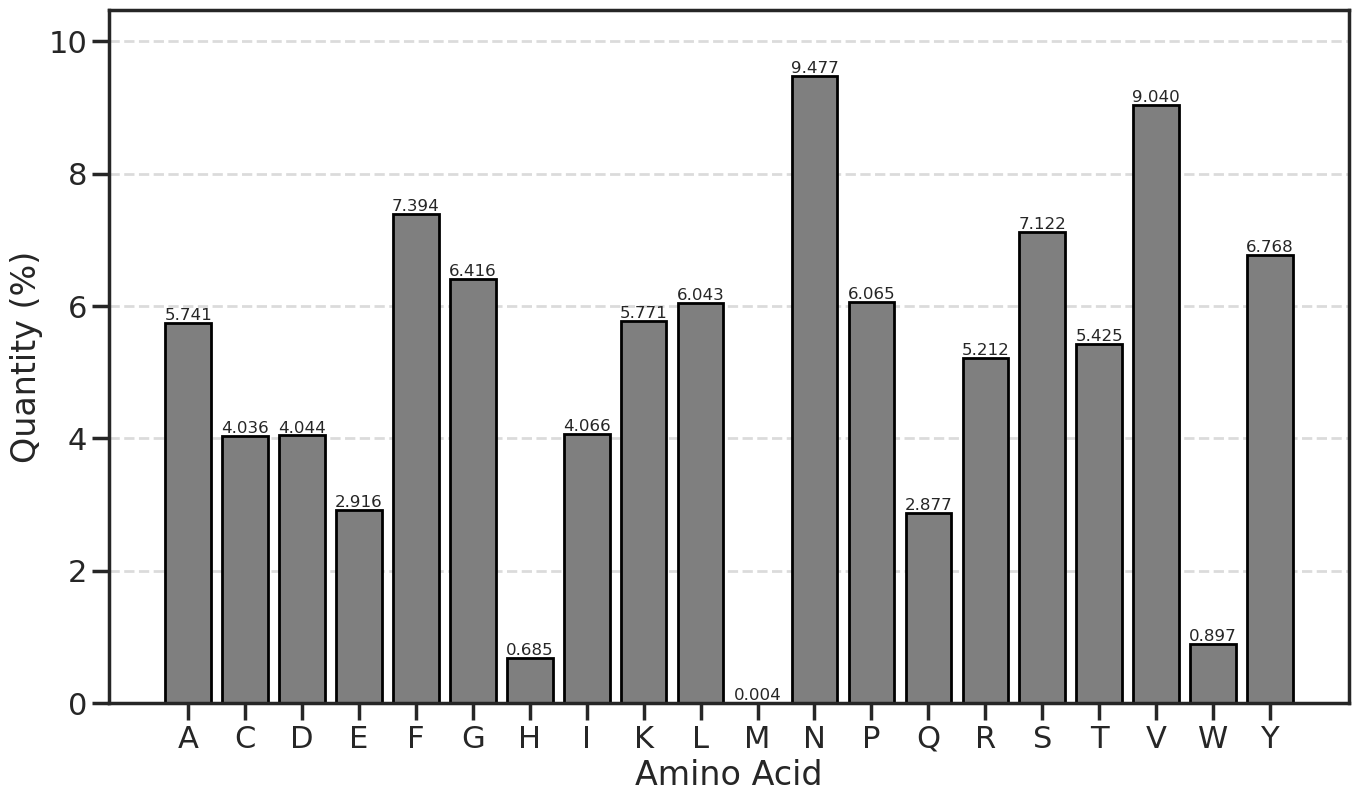

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_aa_distribution(csv_file:str):
    df = pd.read_csv(csv_file, sep=',', header=0)
    #df = df[df['variant'] != "UNKNOWN"]

    aa_dict = defaultdict(int)
    m_seqs = defaultdict(list)

    for seq_id, variant, seq in zip(df['seq_id'], df['variant'], df['sequence']):
        m_count = 0
        for aa in seq:
            aa_dict[aa] += 1
            if aa == "M":
                m_count += 1

        if "M" in seq:
            if variant not in m_seqs:
                m_seqs[variant] = [0, 0] 

            if m_count == 1:
                m_seqs[variant][0] += 1
            elif m_count > 1:
                m_seqs[variant][1] += 1

    n_m_seqs = sum([sum(counts) for counts in m_seqs.values()])
    print(f"M count: {aa_dict['M']} AAs, n seqs with M: {n_m_seqs} (out of {len(df)}), % seqs with M: {n_m_seqs/len(df)*100:.2f}%")
    print(m_seqs)

    amino_acids = sorted(aa_dict.keys())
    counts = [aa_dict[aa] for aa in amino_acids]
    total_counts = sum(counts)
    percentages = [(count/total_counts) * 100 for count in counts]

    # Create a bar plot to visualize the distribution
    sns.set_style("ticks")
    sns.set_context("poster")
    fig, ax = plt.subplots(figsize=(16, 9))

    x = np.arange(len(aa_dict))
    bars = plt.bar(x, percentages, color="tab:grey", edgecolor='black')

    # Add bar labels
    for i, percentage in enumerate(percentages):
        plt.text(i, percentage, f'{percentage:.3f}', ha='center', va='bottom', fontsize=12)
    
    plt.xlabel('Amino Acid')
    plt.xticks(x, amino_acids)
    plt.ylim(0, max(percentages)+1)
    plt.ylabel('Quantity (%)')
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    save_path = "bar/rbd_aa_distribution"
    plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')

data_file = "../../data/rbd/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.csv"
plot_aa_distribution(data_file)

Now let's take a look at the sequence length distribution.

131 1 0.0002878261069792074%
141 1 0.0002878261069792074%
144 1 0.0002878261069792074%
146 1 0.0002878261069792074%
147 1 0.0002878261069792074%
148 2 0.0005756522139584149%
150 1 0.0002878261069792074%
156 1 0.0002878261069792074%
158 2 0.0005756522139584149%
160 7 0.002014782748854452%
162 1 0.0002878261069792074%
164 3 0.0008634783209376224%
166 1 0.0002878261069792074%
169 1 0.0002878261069792074%
170 3 0.0008634783209376224%
171 3 0.0008634783209376224%
174 1 0.0002878261069792074%
175 1 0.0002878261069792074%
176 2 0.0005756522139584149%
179 2 0.0005756522139584149%
181 2 0.0005756522139584149%
183 1 0.0002878261069792074%
184 4 0.0011513044279168297%
185 4 0.0011513044279168297%
186 1 0.0002878261069792074%
187 1 0.0002878261069792074%
188 9 0.0025904349628128667%
189 8 0.0023026088558336594%
190 5 0.0014391305348960372%
191 8 0.0023026088558336594%
192 16 0.004605217711667319%
193 30 0.008634783209376225%
194 5 0.0014391305348960372%
195 8 0.0023026088558336594%
196 14 0.004029

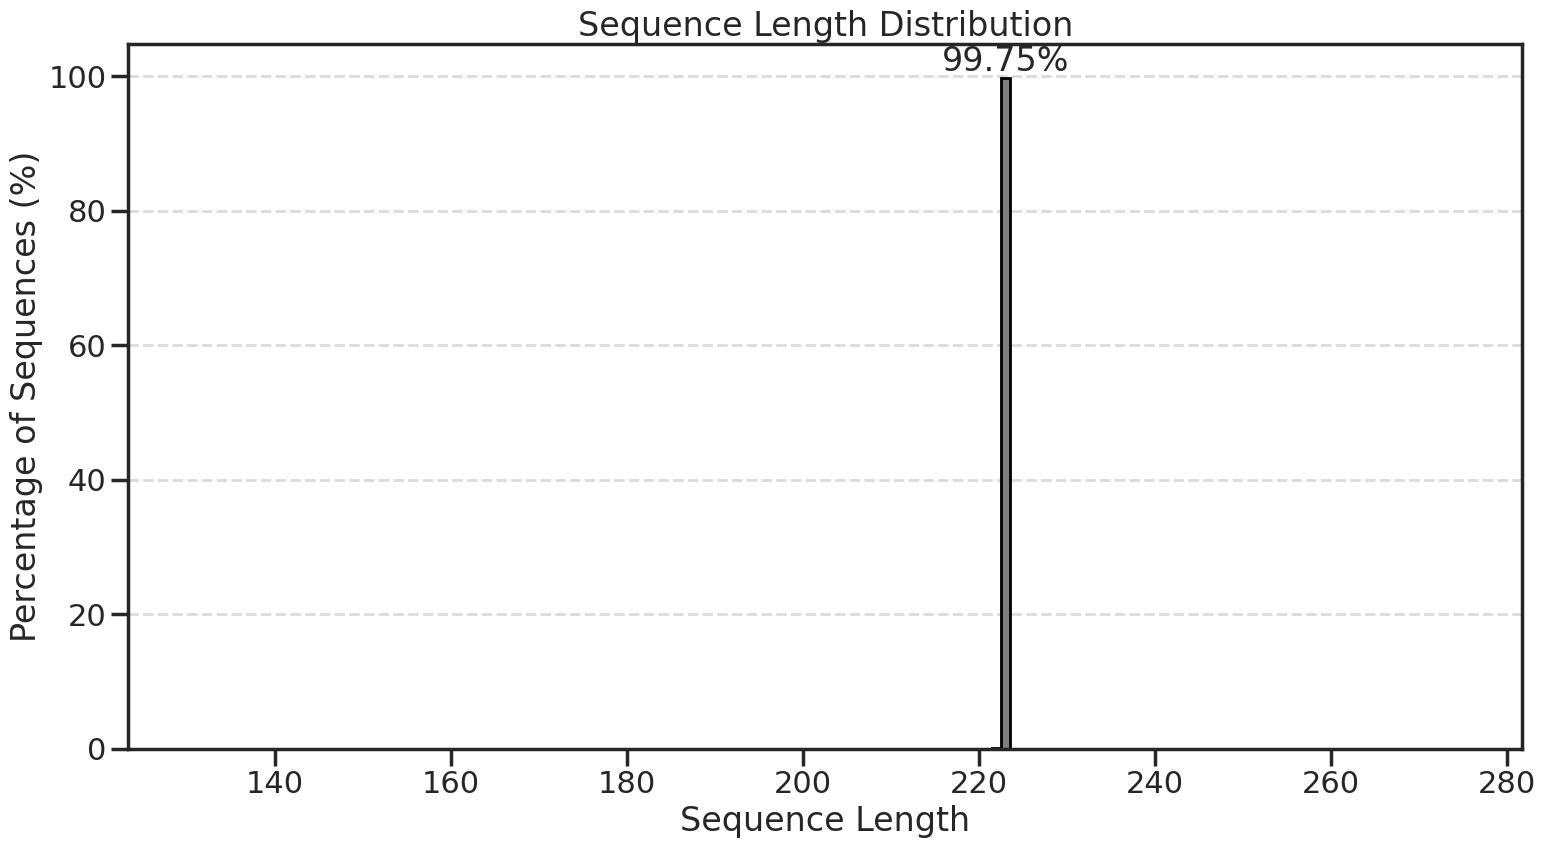

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# --- Configuration ---
csv_file = "../../data/rbd/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.csv"      # Path to your CSV file
df = pd.read_csv(csv_file, sep=',', header=0)

# --- Count occurrences of each length ---
lengths = df['sequence'].str.len()
length_counts = Counter(lengths)

# Sort by sequence length
sorted_lengths = sorted(length_counts.items())
lengths_list, counts = zip(*sorted_lengths)
total_sequences = len(df)
percentages = [(count / total_sequences) * 100 for count in counts]
for i in range(len(lengths_list)):
    print(f"{lengths_list[i]} {counts[i]} {percentages[i]}%")

# # --- Output as tab-delimited file ---
# with open('length_distribution.txt', 'w') as out:
#     out.write('length,count,percentage\n')
#     for i in range(len(lengths_list)):
#         out.write(f"{lengths_list[i]},{counts[i]},{percentages[i]}%\n")

# --- Plot the distribution ---
sns.set_style("ticks")
sns.set_context("poster")
plt.figure(figsize=(16,9))
plt.bar(lengths_list, percentages, width=1.0, color="tab:grey", edgecolor='black')

# Add bar labels
max_pct = max(percentages)
for x, pct in zip(lengths_list, percentages):
    if pct == max_pct:
        plt.text(x, pct, f'{pct:.2f}%', ha='center', va='bottom')

plt.xlabel('Sequence Length')
plt.ylabel('Percentage of Sequences (%)')
plt.title('Sequence Length Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('bar/rbd_sequence_length_distribution.png')
plt.show()